### Language Modeling With an RNN
Data:<br>
https://www.kaggle.com/competitions/nlp-getting-started

### BERT model 

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
# use official BERT tokenization script
if not os.path.isfile('tokenization.py'):
  !wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece
import tokenization
import matplotlib.pyplot as plt

random_state = 123
tf.random.set_seed(random_state)
np.random.seed(random_state)
model_type = 'BERT'

     |████████████████████████████████| 1.2MB 7.5MB/s 


In [2]:
# use sample code from tensorflow hub
# model is called as follows on tokenized text input, 
# an input mask to hold out padding tokens, and segment types when input mixes with different segments
max_seq_length = 128 
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name='input_word_ids')
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name='input_mask')
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name='segment_ids')
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1',
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [3]:
# helper function for BERT encoding using tokenizer
# reference: https://medium.com/analytics-vidhya/bert-for-identifying-disasters-from-tweets-50eeb6844302
def bert_encode(texts, tokenizer, max_len=512): # BERT max_len = 512
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [4]:
# load data
train = pd.read_csv('drive/MyDrive/input/nlp-getting-started/train.csv')
test = pd.read_csv('drive/MyDrive/input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv('drive/MyDrive/input/nlp-getting-started/sample_submission.csv')

In [5]:
# define X_train, y_train, X_test
# encode with BERT tokenizer script
X_train = bert_encode(train['text'].to_numpy(), tokenizer, max_len=max_seq_length)
X_test = bert_encode(test['text'].to_numpy(), tokenizer, max_len=max_seq_length)
y_train = train['target'].to_numpy()

In [6]:
# construct model
out = tf.keras.layers.Dense(1, activation='sigmoid')(pooled_output)
model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [7]:
# callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_'+model_type+'.h5', monitor='val_loss',
                                                verbose=1, save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, 
                                                 verbose=1, min_lr=0)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# compile and fit
model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, batch_size=16, epochs=3, verbose=1,
                    validation_split=0.2, 
                    # callbacks = [reduce_lr, es, checkpoint],
                    callbacks = [reduce_lr, checkpoint]
                    )

Epoch 1/3
381/381 [==============================] - 350s 847ms/step - loss: 0.5159 - accuracy: 0.7638 - val_loss: 0.3915 - val_accuracy: 0.8424

Epoch 00001: val_loss improved from inf to 0.39149, saving model to model_BERT.h5
Epoch 2/3
381/381 [==============================] - 320s 841ms/step - loss: 0.2821 - accuracy: 0.9017 - val_loss: 0.3951 - val_accuracy: 0.8359

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.

Epoch 00002: val_loss did not improve from 0.39149
Epoch 3/3
381/381 [==============================] - 321s 842ms/step - loss: 0.1580 - accuracy: 0.9398 - val_loss: 0.4373 - val_accuracy: 0.8450

Epoch 00003: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.

Epoch 00003: val_loss did not improve from 0.39149


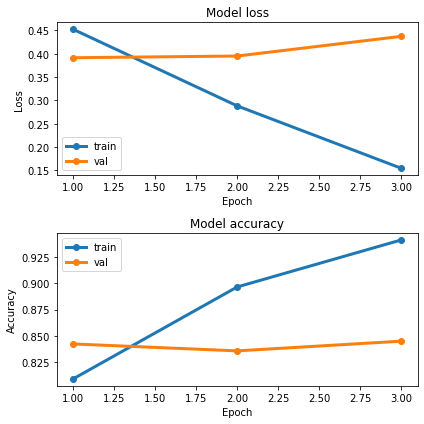

In [8]:
# plot history
df_plot = pd.DataFrame(history.history)
fig, axs = plt.subplots(2,1, figsize=(6,6))
axs[0].plot(df_plot.index+1, df_plot['loss'], '-o', lw=3, label='train')
axs[0].plot(df_plot.index+1, df_plot['val_loss'], '-o', lw=3, label='val')
axs[0].set(title='Model loss', ylabel='Loss')
axs[1].plot(df_plot.index+1, df_plot['accuracy'], '-o', lw=3, label='train')
axs[1].plot(df_plot.index+1, df_plot['val_accuracy'], '-o', lw=3, label='val')
axs[1].set(title='Model accuracy', ylabel='Accuracy')
axs[0].set_ylim([None, None])
axs[1].set_ylim([None, None])
for ax in axs:
  ax.set_xlabel('Epoch')
  ax.legend()
fig.tight_layout()
plt.show()
fig.savefig('train_hist_'+model_type+'.pdf', format='pdf', bbox_inches='tight')

In [9]:
# reload best weights and evaluate model
model.load_weights('model_'+model_type+'.h5')
model.evaluate(X_train, y_train)

238/238 [==============================] - 116s 486ms/step - loss: 0.3179 - accuracy: 0.8855


[0.3179369568824768, 0.8854590654373169]

In [10]:
# predict
y_pred = model.predict(X_test)
y_pred = (y_pred>=0.5).astype(int).flatten()
# prep submission
submission = sample_submission.copy()
submission['target'] = y_pred
submission.to_csv('submission_'+model_type+'.csv', index=False)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
